In [1]:
# %matplotlib qt5
%matplotlib inline
import numpy as np
from numpy import linalg as la
import matplotlib.pylab as plt
from scipy.optimize import fsolve
import math
import statsmodels.api as sm
from scipy.stats import norm
import seaborn as sns
from scipy import stats
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

In [2]:
import scipy
from functools import partial
def odeIntegral(x,t,J,I=0):
    x = np.squeeze(x)
    x = np.reshape(x,(len(x),1))
    # dxdt = -x+J@np.tanh(x)#+I[0]
    dxdt = -x+J@x+I[0]
    return np.squeeze(dxdt)
def odesimulation(t,xinit,Jpt,I):
	return scipy.integrate.odeint(partial(odeIntegral,J=Jpt,I=I),xinit,t)
shiftx = 1.5
def odeIntegralP(x,t,J,I=0):
	x = np.squeeze(x)
	x = np.reshape(x,(len(x),1))
	# print('size:',np.shape(x),np.shape(J@np.tanh(x)))
	dxdt = -x+J@(1.0+np.tanh(x-shiftx))
	return np.squeeze(dxdt)
def odesimulationP(t,xinit,Jpt,I):
	return scipy.integrate.odeint(partial(odeIntegralP,J=Jpt,I=I),xinit,t)

In [8]:
'''.sh code run SONETs'''
# # for value in {0.   0.14 0.28 0.42 0.56 0.7  0.84 0.98 1.12 1.26 1.4 }; do
# #     ./run_secorder 1000 0.2 $(echo "$value*2" | bc) $value $value 1 1
# # done
# for seed in {1 7 8 12 13 19 28 31 33 39 40 42 48 50 51 52 55 56 59 65 66 67 69 70 75 76 78 82 83 86 94}; do     mkdir -p "seed_$seed"; done

# for seed in {0..36}; do     mkdir -p "seed_$seed"; done

#### Fig3 Construct True Sparse Networks from SONETs adjacency matrix

multiple values

In [3]:
ntau = 10#21#
trials = 30+6

''' Parameters used for all networks (reciprocal and chain)'''
N =1500#1750#2000
J = 1/np.sqrt(1500)*0.5
### get the current path location and read the data file
import os
strr= os.getcwd()
print(strr)

c = 0.2
# sigma2 = N*c*(1-c)*J**2
g, gamma = 6.8, 1/4.0#1.5,1/1.# 6.8, 1/4.0#1.5,1/1.#
NE = int(N/(1+gamma))
NI = int(gamma*NE)
N  = NE+NI
print(N,NE,NI)
ALPHAE, ALPHAI = NE/N, NI/N
KE, KI = int(c*NE), int(c*NI) ### fixed out-degree
print('Network size:',N)
print('number of connected E/I neurons:',KE,KI)
print('non-zero J:',J)
ji,je = g*J,J 

### define the network parameters of the diluted Gaussian matrix 
ge, gi = np.sqrt(je**2*c*(1-c)*N), np.sqrt(ji**2*c*(1-c)*N) 
hat_sigmae, hat_sigmai = np.sqrt(c*(1-c)), np.sqrt(c*(1-c))### standard deviation of the adjacency matrix
sigmae,sigmai = np.sqrt(c*(1-c)*J**2*N), np.sqrt(c*(1-c)*(-g*J)**2*N)### with magnitude of the coupling
JE,JI = je*c*NE, ji*c*NI 
lambda0 = JE-JI 
print('lambda0:',lambda0)
print('ge,gi:',ge,gi)
print('JE,JI:',JE,JI)

tau_series = np.linspace(0,0.225,ntau)# np.linspace(0.25,0.4,ntau)#
alpha_series = (tau_series*c*(1-c)+c**2)/c**2-1
alpha_series_rec = (tau_series*2*c*(1-c)+c**2)/c**2-1
print('alpha used in SONETs:',alpha_series)
print('alpha_reciprocal:',alpha_series_rec)
# ((alpha_series+1)*c**2-c**2)/c/(1-c)

e:\Dropbox\DailyWork\Allen_project\Preparation_Paper_Figures\PRX_prune\PRX_numeric\LocalChainMotifs_ParadoxicalEffect
1500 1200 300
Network size: 1500
number of connected E/I neurons: 240 60
non-zero J: 0.012909944487358056
lambda0: -2.168870673876153
ge,gi: 0.2 1.36
JE,JI: 3.0983866769659336 5.267257350842087
alpha used in SONETs: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
alpha_reciprocal: [0.  0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8]


In [4]:
# tau_series = np.array([0.025, 0.05 , 0.075, 0.1  ])
eigvchn_series, eigrvec_series, eiglvec_series = np.zeros((trials,ntau,N),dtype=complex), np.zeros((trials,ntau,N,2)), np.zeros((trials,ntau,N,2))
eiglvec0_series, norml0_series = np.zeros((trials,ntau,N,2)), np.zeros((trials,ntau+1,N)) 
### normalization for left and right eigenvectors 
norms_for_lvec, norms_for_rvec = np.zeros((trials,ntau+1,2)), np.zeros((trials,ntau+1,2))
### also have the reconstructed left and right eigenvectors 
eigrvec_series_rec, eiglvec_series_rec = np.zeros((trials,ntau,N,2)), np.zeros((trials,ntau,N,2))
### mean connectivity
nvec, mvec = np.zeros((N,1)), np.ones((N,1))
nvec[:NE,0], nvec[NE:,0] = N*JE/NE, -N*JI/NI
Jbar = mvec@nvec.T/N 
## TEST THE EIGENVALUES OF THE MEAN MATRIX 
eigvJ0, eigvecJ0 = la.eig(Jbar)
print('eigvJ0:',eigvJ0[0],' theory:',JE-JI)
### mean left and right eigenvectors
leigvec0, reigvec0 = np.zeros((N,N)), np.zeros((N,N))
norm_left = np.zeros(2)
## first eigenvector
leigvec0[:,0], reigvec0[:,0] = nvec[:,0]/(JE-JI)/np.sqrt(N), mvec[:,0]/np.sqrt(N)
norm_left[0]  = la.norm(leigvec0[:,0])
leigvec0[:,0] = leigvec0[:,0]/norm_left[0]
norml0_series[:,0,0] = np.sum(leigvec0[:,0]*reigvec0[:,0])
## second eigenvector
kk = np.sqrt(NE*JI**2+NI*JE**2)
reigvec0[:NE,1], reigvec0[NE:,1] = JI/kk,JE/kk 
leigvec0[:NE,1], leigvec0[NE:,1] = -kk/(JE-JI)/NE,kk/(JE-JI)/NI 
norm_left[1]  = la.norm(leigvec0[:,1])
leigvec0[:,1] = leigvec0[:,1]/norm_left[1]
norml0_series[:,0,1] = np.sum(leigvec0[:,1]*reigvec0[:,1])
outerproduct = np.sum(leigvec0[:,0]*reigvec0[:,1])#*norm_left
### compute the square of the random connectivity 
Z2E = N*J**2*hat_sigmae**2*tau_series*ALPHAE-N*g*J**2*hat_sigmae*hat_sigmai*tau_series*ALPHAI
Z2I = -N*g*J**2*hat_sigmae*hat_sigmai*tau_series*ALPHAE+N*g**2*J**2*hat_sigmai**2*tau_series*ALPHAI
DeltaZ2E, DeltaZ2I = Z2E[1]-Z2E[0],Z2I[1]-Z2I[0] ### for practical use
print('DeltaZ2E,DeltaZ2I:',DeltaZ2E,DeltaZ2I)
DeltaZ2 = np.zeros((N,N))
DeltaZ2[:,:NE], DeltaZ2[:,NE:] = DeltaZ2E, DeltaZ2I

### E population and I population separately
Z2E_E, Z2I_E = N*J**2*hat_sigmae**2*tau_series*ALPHAE, -N*g*J**2*hat_sigmae*hat_sigmai*tau_series*ALPHAI
Z2E_I, Z2I_I = -N*g*J**2*hat_sigmae*hat_sigmai*tau_series*ALPHAE, N*g**2*J**2*hat_sigmai**2*tau_series*ALPHAI
DeltaZ2E_E, DeltaZ2I_E = Z2E_E[1]-Z2E_E[0],Z2I_E[1]-Z2I_E[0] ### for practical use
DeltaZ2E_I, DeltaZ2I_I = Z2E_I[1]-Z2E_I[0],Z2I_I[1]-Z2I_I[0] ### for practical use
DeltaZ2_E, DeltaZ2_I = np.zeros((N,N)),np.zeros((N,N))
DeltaZ2_E[:,:NE], DeltaZ2_E[:,NE:] = DeltaZ2E_E, DeltaZ2I_E

eigvJ0: (-2.1688706738761887+0j)  theory: -2.168870673876153
DeltaZ2E,DeltaZ2I: -0.0005599999999999998 0.0038080000000000006


In [8]:
trials = 36
alphachns     = ['0.000','0.100','0.200','0.300','0.400','0.500','0.600','0.700','0.800','0.900']
alphachns_rec = ['0.000','0.200','0.400','0.600','0.800','1.000','1.200','1.400','1.600','1.800']
# alphachns_arr = np.array([0.1,0.2,0.3,0.4])
eigvchn_series = np.zeros((trials,len(alphachns),N),dtype=complex)
eiglvec0norm_series= np.zeros((trials,ntau,N,2))
leig0mean_series = np.zeros((trials,ntau,N,2))
leig0pre_series = np.zeros((trials,ntau,N,2))
norm_4rvec_series, norm_4lvec_series = np.zeros((trials,ntau,2)),np.zeros((trials,ntau,2))
norm_4lvec_series_ = np.zeros((trials,ntau,2))

intg_mean_series  = np.zeros((trials,ntau,N,2,3))### mean overlap matrix rank and 
# tauchns_arr = alphachns_arr*c**2/c/(1-c)
seedss = np.array([1, 4, 8, 10, 13, 14, 18, 19, 25, 26, 31, 32, 34, 36, 40, 43, 44, 49, 52, 53, 55 ,60, 62, 64, 71, 73, 76, 78, 81, 82, 83,84, 85, 86, 87, 88, 93, 94, 95])
# seedss = np.arange(1,37)
for ktrial in range(trials):
    seed =seedss[ktrial]
    z_pre = 0
    for idxalpha, alphachn in enumerate(alphachns[:]):
        # if idxalpha <8:
        #     continue
        if idxalpha == 0:       
            file_path = 'K:\\Projects\\Allen_motif\\PRXL_data\\sonets\\N1500\\seed_'+str(seed)+'\\w_1500_0.200_'+alphachns_rec[idxalpha]+'_'+alphachn+'_'+alphachn+'_0.000_'+str(seed)+'.dat'
        else:
            file_path = 'K:\\Projects\\Allen_motif\\PRXL_data\\sonets\\N1500\\seed_'+str(seed)+'\\w_1500_0.200_'+alphachns_rec[idxalpha]+'_'+alphachn+'_'+alphachn+'_1.000_'+str(seed)+'.dat'
        Jmat = np.zeros((N,N))
        count =0
        with open(file_path, 'r') as file:
            content = file.read()
            if content == '0':
                print('File is empty') 
            else:
                for line in content.split('\n'):
                    if line:
                        Jmat[count,:]=([(x) for x in line.split()])
                        count +=1
        # ### adding excitatory and inhibitory  
        # Zmat2 = (Jmat-c)@(Jmat-c)
        # chainsum = 0
        # for i in range(1000):
        #     for j in range(1000):
        #         if i!=j:
        #             chainsum += Zmat2[i,j]
        # print('chainsum,',chainsum/1000/999)           
        Jmat[:,:NE] = Jmat[:,:NE]*je
        Jmat[:,NE:] = Jmat[:,NE:]*(-ji)

        ktrial, it = ktrial, idxalpha
        # ### full rank simulation
        # xinit = np.squeeze(np.random.normal(0, 1E-2, (1, N)))
        # xc_temporal = odesimulation(tt, xinit, Jmat, Inp)
        # firing_rateeq[ktrial,it,:] = xc_temporal[-1,:].copy()
            
        zr = Jmat - Jbar
        ### compute the eigenvalues and eigenvectors of the matrix
        eigvchn, eigrvec = la.eig(Jmat)
        ## sort the eigenValues by it's norm of the real part 
        idxeigv = np.argsort(np.abs(eigvchn))
        idxeigv = idxeigv[::-1]
        eigvchn, eigrvec = eigvchn[idxeigv],eigrvec[:,idxeigv]
        
        eigvchn_,eiglvec = la.eig(Jmat.copy().T)
        idxeigv = np.argsort(np.abs(eigvchn_))
        idxeigv = idxeigv[::-1]
        eigvchn_, eiglvec = eigvchn[idxeigv],eiglvec[:,idxeigv]
        
        ### normalization
        reig    = np.squeeze(eigrvec[:,:].copy())
        leig0   = np.squeeze(eiglvec[:,:].copy()) 
        normval = np.sum(reig.copy()*leig0.copy(),axis=0)
        
        norml0_series[ktrial,it+1,:] = normval.copy() ### normalization factor shift right 1byte
        normval = np.repeat(np.reshape(normval,(1,N)),N,axis=0)
        leig = leig0.copy()/normval.copy()### left eigenvector normalization to make <l|r>=1
        if np.mean(reig[:NE,0])<0:
            reig[:,0]*=-1
            leig[:,0]*=-1
            leig0[:,0]*=-1
        if np.mean(reig[:NE,1])<0: ### the second rank-1 component is negative
            reig[:,1]*=-1
            leig[:,1]*=-1
            leig0[:,1]*=-1
               
              
        print('seed:',seed,'alphachn:',alphachn,'idxalpha:',idxalpha)
        print('eigenvalues',eigvchn[:2])
        
        DELTA_Z = np.zeros((N,N))
        DELTA_Z = zr-z_pre  
        hzr = DELTA_Z.copy()
        
        eigvchn_series[ktrial,it,:] = eigvchn[:] 
        eigrvec_series[ktrial,it,:,:]  = reig[:,:2].copy()#eigvecw_norm.copy()#
        eiglvec_series[ktrial,it,:,:]  = leig[:,:2].copy()#eigvect_norm.copy()#
        eiglvec0_series[ktrial,it,:,:] = leig0[:,:2].copy()#eigvect_norm.copy()#
        for iii in range(2):
            eiglvec0norm_series[ktrial,it,:,iii] = leig0[:,iii].copy()/normval[iii,iii]   
        
        z_pre = zr.copy()    

C:\Users\Administrator\AppData\Local\Temp\ipykernel_49112\373441706.py:72: ComplexWarning: Casting complex values to real discards the imaginary part
  norml0_series[ktrial,it+1,:] = normval.copy() ### normalization factor shift right 1byte
C:\Users\Administrator\AppData\Local\Temp\ipykernel_49112\373441706.py:93: ComplexWarning: Casting complex values to real discards the imaginary part
  eigrvec_series[ktrial,it,:,:]  = reig[:,:2].copy()#eigvecw_norm.copy()#
C:\Users\Administrator\AppData\Local\Temp\ipykernel_49112\373441706.py:94: ComplexWarning: Casting complex values to real discards the imaginary part
  eiglvec_series[ktrial,it,:,:]  = leig[:,:2].copy()#eigvect_norm.copy()#
C:\Users\Administrator\AppData\Local\Temp\ipykernel_49112\373441706.py:95: ComplexWarning: Casting complex values to real discards the imaginary part
  eiglvec0_series[ktrial,it,:,:] = leig0[:,:2].copy()#eigvect_norm.copy()#
C:\Users\Administrator\AppData\Local\Temp\ipykernel_49112\373441706.py:97: ComplexWarn

seed: 1 alphachn: 0.000 idxalpha: 0
eigenvalues [-2.13443483+0.j          0.53690096+0.37456855j]
seed: 1 alphachn: 0.100 idxalpha: 1
eigenvalues [-2.43940929+0.j          0.53158705+0.40464461j]
seed: 1 alphachn: 0.200 idxalpha: 2
eigenvalues [-2.67471052+0.j         0.65192304-0.0635404j]
seed: 1 alphachn: 0.300 idxalpha: 3
eigenvalues [-2.88213532+0.j         -0.22525165+0.60818452j]
seed: 1 alphachn: 0.400 idxalpha: 4
eigenvalues [-3.13936889+0.j          0.67598319+0.12688303j]
seed: 1 alphachn: 0.500 idxalpha: 5
eigenvalues [-3.24914778+0.j  0.85959095+0.j]
seed: 1 alphachn: 0.600 idxalpha: 6
eigenvalues [-3.42882751+0.j  1.13025718+0.j]


C:\Users\Administrator\AppData\Local\Temp\ipykernel_49112\373441706.py:74: RuntimeWarning: divide by zero encountered in divide
  leig = leig0.copy()/normval.copy()### left eigenvector normalization to make <l|r>=1
C:\Users\Administrator\AppData\Local\Temp\ipykernel_49112\373441706.py:74: RuntimeWarning: invalid value encountered in divide
  leig = leig0.copy()/normval.copy()### left eigenvector normalization to make <l|r>=1


seed: 1 alphachn: 0.700 idxalpha: 7
eigenvalues [-3.5172645 +0.j  1.30108854+0.j]
seed: 1 alphachn: 0.800 idxalpha: 8
eigenvalues [-3.67281233+0.j  1.48558075+0.j]
seed: 1 alphachn: 0.900 idxalpha: 9
eigenvalues [-3.79296001+0.j  1.6309936 +0.j]
seed: 4 alphachn: 0.000 idxalpha: 0
eigenvalues [-2.06938122+0.j  0.66181737+0.j]
seed: 4 alphachn: 0.100 idxalpha: 1
eigenvalues [-2.35313808+0.j          0.61676952+0.26261604j]
seed: 4 alphachn: 0.200 idxalpha: 2
eigenvalues [-2.45709611+0.j          0.60206111+0.24415444j]
seed: 4 alphachn: 0.300 idxalpha: 3
eigenvalues [-2.67297179+0.j          0.62217701+0.29840375j]
seed: 4 alphachn: 0.400 idxalpha: 4
eigenvalues [-2.70824297+0.j          0.29837797+0.58780704j]
seed: 4 alphachn: 0.500 idxalpha: 5
eigenvalues [-2.77051873+0.j          0.47657281+0.42647119j]
seed: 4 alphachn: 0.600 idxalpha: 6
eigenvalues [-2.86667361+0.j          0.53994398+0.37192998j]
seed: 4 alphachn: 0.700 idxalpha: 7
eigenvalues [-3.06050767+0.j          0.56279925

In [10]:
### compute the theoretical outliers and the spectral radius
### recording
eigvchn_theo   = np.zeros((ntau,2))
radius_theo_map = np.zeros(ntau)
### print variables and parameters of the adjacency matrix 
print('-------------------')
print('N:',N)
print('g:',g)
print('gamma:',gamma)
print('J:',J)
print('JE,JI:',JE,JI)
print('ge,gi:',ge,gi)
print('c:',c)
print('je,ji:',je,ji)
print('-------------------')
'''Theoretical eigenvalue outliers and radius of the bulk'''
ce, ci = c,c
for it, tau in enumerate(tau_series):
    ### mean connectivity 
    je, ji = J, g*J
    hat_sigmae, hat_sigmai = np.sqrt(ce*(1-ce)),np.sqrt(ci*(1-ci))
    sigmae, sigmai = np.sqrt(je**2*ce*(1-ce)*N), np.sqrt(ji**2*ci*(1-ci)*N) 
    ### generate tau_div_vec, tau_con_vec, tau_rec_vec, tau_chn_vec
    tau_div_vec, tau_con_vec, tau_rec_vec, tau_chn_vec = np.zeros(2),np.zeros((2,2)),np.zeros((2,2)),np.zeros((2,2))
    ### YS: alltaus do not have E-I polarity
    tau_div_vec = np.array([tau,tau])
    tau_con_vec = np.array([[tau,tau],[tau,tau]])
    # tau_rec_vec = np.array([[0,0],[0,0]])
    tau_rec_vec = np.array([[2*tau,2*tau],[2*tau,2*tau]])
    tau_chn_vec = np.array([[tau,tau],[tau,tau]])
    # gamma = 1.0 ## NI/NE
    sigma = np.sqrt(sigmae**2/(1+gamma)+sigmai**2*gamma/(1+gamma))
    ### compute the radius 
    # compute a single number for multiple populations
    tau_div_num = hat_sigmae**2*tau_div_vec[0]+gamma*g**2*hat_sigmai**2*tau_div_vec[1]
    tau_div_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_div = tau_div_num/tau_div_den

    tau_con_num = hat_sigmae**2*tau_con_vec[0,0]+gamma*g**2*hat_sigmai**2*tau_con_vec[1,1]
    tau_con_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_con  = tau_con_num/tau_con_den

    tau_rec_num = hat_sigmae**2*tau_rec_vec[0,0] - (1+gamma)*g*hat_sigmae*hat_sigmai*tau_rec_vec[0,1]+gamma*g**2*hat_sigmai**2*tau_rec_vec[1,1]
    tau_rec_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_rec = tau_rec_num/tau_rec_den/2.0 

    tau_chn_num = hat_sigmae**2*tau_chn_vec[0,0] - 0.5*(1+gamma)*g*hat_sigmae*hat_sigmai*(tau_chn_vec[0,1]+tau_chn_vec[1,0])+gamma*g**2*hat_sigmai**2*tau_chn_vec[1,1]
    tau_chn_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_chn = tau_chn_num/tau_chn_den/2.0

    radius_theo = (1.0-tau_con-tau_div+tau_rec-2*tau_chn)/np.sqrt(1-tau_con-tau_div)*sigma
    
    radius_theo_map[it] = radius_theo
            
### theoretical prediction of the eigenvalues

org_k = J*N*(ALPHAE-g*ALPHAI)/2.0

eigvchn_theo[:,0] = org_k*(c+np.sqrt(c**2+4*c*(1-c)*tau_series))
eigvchn_theo[:,1] = org_k*(c-np.sqrt(c**2+4*c*(1-c)*tau_series))

### compute the numerical radius
radius_num_map = np.zeros((trials,ntau))
for ktrial in range(trials):
    for it in range(ntau): 
        eigvchn = eigvchn_series[ktrial,it,:].copy()

        eigvchn_real = np.real(eigvchn)
        eigvchn_real = np.sort(eigvchn_real)
        eigvchn_real = eigvchn_real[::-1]

        radius = (eigvchn_real[2])
        radius_num_map[ktrial,it] = radius

#### print trial by trial the first two eigenvallues
for ktrial in range(trials):
    eigvchn = eigvchn_series[ktrial,:,:].copy()
    eigvchn_real = (eigvchn)
# ### delete the 17th trial
# eigvchn_series = np.delete(eigvchn_series,17,axis=0) #for ConnStats_Adjacency_12OctDense_.npz
### sorting the 3 maximum eigvchn_series[:,-1,0].real and 3 minimum
eigvchn_real = eigvchn_series[:,-1,0].real.copy()
### sorting eigvchn_real 
idx = np.argsort(eigvchn_real)
idx_eff = idx[3:-3]
print('effective trials:',idx_eff,len(idx_eff))


-------------------
N: 1500
g: 6.8
gamma: 0.25
J: 0.012909944487358056
JE,JI: 3.0983866769659336 5.267257350842087
ge,gi: 0.2 1.36
c: 0.2
je,ji: 0.012909944487358056 0.08778762251403478
-------------------
effective trials: [ 8 20 21 29 24  9 17 15  4  0 30 35 13 14  3 31  5 25 18 28 10 33 12 34
 26  1 16 23  7 22] 30


Generate Fig3 using True Sparse Networks (via SONETs)

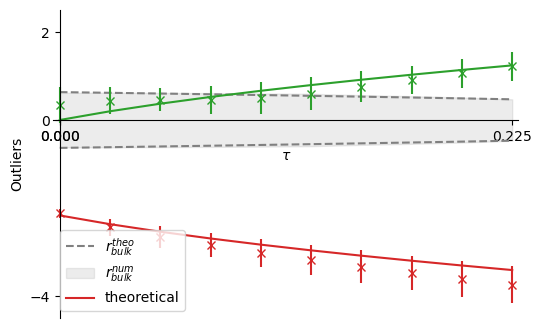

In [11]:
### plot the numerical and theoretical eigenvalues outliers
fig,ax = plt.subplots(figsize=(6,4))
### label is r_{bulk}^{num}
ax.plot(tau_series,radius_theo_map,'gray',linestyle='--',label=r'$r_{bulk}^{theo}$')
ax.plot(tau_series,-radius_theo_map,'gray',linestyle='--')
# ax.plot(tau_series,np.mean(radius_num_map,axis=0),'k',label=r'$r_{bulk}^{num}$')
ax.fill_between(tau_series,np.mean(radius_num_map,axis=0),-np.mean(radius_num_map,axis=0),color='gray',alpha=0.15,label=r'$r_{bulk}^{num}$')
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('Radius')
ax.legend()

ax.plot(tau_series,eigvchn_theo[:,0],'tab:red',label='theoretical')
ax.plot(tau_series,eigvchn_theo[:,1],'tab:green')

### plot error bar  
ax.errorbar(tau_series,np.mean(eigvchn_series[idx_eff,:,0].real,axis=0),yerr=np.std(eigvchn_series[idx_eff,:,0].real,axis=0),fmt='x',color='tab:red',ecolor='tab:red',alpha=1,ls='',elinewidth=1.5)

ax.errorbar(tau_series,np.mean(eigvchn_series[idx_eff,:,1].real,axis=0),yerr=np.std(eigvchn_series[idx_eff,:,1].real,axis=0),fmt='x',color='tab:green',ecolor='tab:green',alpha=1,ls='',elinewidth=1.5)
    
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('Outliers')
### set x and y lims as well as ticks
dtau = tau_series[1]-tau_series[0] 
ax.set_xlim([tau_series[0]-dtau/8,tau_series[-1]+dtau/8])
ax.set_xticks([0,tau_series[-1]//2,tau_series[-1]])
ax.set_ylim([-4.5,2.5])
ax.set_yticks([-4,0,2])
ax.legend()
### move the x and y axis to the center
ax.spines['bottom'].set_position(('data',0))
ax.spines['left'].set_position(('data',0))
### set other x-axis invisible
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.show()

#### Strongly connected regime

In [4]:
ntau = 10#21#
trials = 30+6

''' Parameters used for all networks (reciprocal and chain)'''
N =1750#1750#2000
J = 1/np.sqrt(1500)*0.5
### get the current path location and read the data file
import os
strr= os.getcwd()
print(strr)

c = 0.2
# sigma2 = N*c*(1-c)*J**2
g, gamma = 6.8, 1/4.0#1.5,1/1.# 6.8, 1/4.0#1.5,1/1.#
NE = int(N/(1+gamma))
NI = int(gamma*NE)
N  = NE+NI
print(N,NE,NI)
ALPHAE, ALPHAI = NE/N, NI/N
KE, KI = int(c*NE), int(c*NI) ### fixed out-degree
print('Network size:',N)
print('number of connected E/I neurons:',KE,KI)
print('non-zero J:',J)
ji,je = g*J,J 

### define the network parameters of the diluted Gaussian matrix 
ge, gi = np.sqrt(je**2*c*(1-c)*N), np.sqrt(ji**2*c*(1-c)*N) 
hat_sigmae, hat_sigmai = np.sqrt(c*(1-c)), np.sqrt(c*(1-c))### standard deviation of the adjacency matrix
sigmae,sigmai = np.sqrt(c*(1-c)*J**2*N), np.sqrt(c*(1-c)*(-g*J)**2*N)### with magnitude of the coupling
JE,JI = je*c*NE, ji*c*NI 
lambda0 = JE-JI 
print('lambda0:',lambda0)
print('ge,gi:',ge,gi)
print('JE,JI:',JE,JI)

tau_series = np.linspace(0,0.225,ntau)# np.linspace(0.25,0.4,ntau)#
alpha_series = (tau_series*c*(1-c)+c**2)/c**2-1
alpha_series_rec = (tau_series*2*c*(1-c)+c**2)/c**2-1
print('alpha used in SONETs:',alpha_series)
print('alpha_reciprocal:',alpha_series_rec)
# ((alpha_series+1)*c**2-c**2)/c/(1-c)

alpha used in SONETs: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
alpha_reciprocal: [0.  0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8]


In [112]:
# tau_series = np.array([0.025, 0.05 , 0.075, 0.1  ])
eigvchn_series, eigrvec_series, eiglvec_series = np.zeros((trials,ntau,N),dtype=complex), np.zeros((trials,ntau,N,2)), np.zeros((trials,ntau,N,2))
eiglvec0_series, norml0_series = np.zeros((trials,ntau,N,2)), np.zeros((trials,ntau+1,N)) 
### normalization for left and right eigenvectors 
norms_for_lvec, norms_for_rvec = np.zeros((trials,ntau+1,2)), np.zeros((trials,ntau+1,2))
### also have the reconstructed left and right eigenvectors 
eigrvec_series_rec, eiglvec_series_rec = np.zeros((trials,ntau,N,2)), np.zeros((trials,ntau,N,2))
### mean connectivity
nvec, mvec = np.zeros((N,1)), np.ones((N,1))
nvec[:NE,0], nvec[NE:,0] = N*JE/NE, -N*JI/NI
Jbar = mvec@nvec.T/N 
## TEST THE EIGENVALUES OF THE MEAN MATRIX 
eigvJ0, eigvecJ0 = la.eig(Jbar)
print('eigvJ0:',eigvJ0[0],' theory:',JE-JI)
### mean left and right eigenvectors
leigvec0, reigvec0 = np.zeros((N,N)), np.zeros((N,N))
norm_left = np.zeros(2)
## first eigenvector
leigvec0[:,0], reigvec0[:,0] = nvec[:,0]/(JE-JI)/np.sqrt(N), mvec[:,0]/np.sqrt(N)
norm_left[0]  = la.norm(leigvec0[:,0])
leigvec0[:,0] = leigvec0[:,0]/norm_left[0]
norml0_series[:,0,0] = np.sum(leigvec0[:,0]*reigvec0[:,0])
## second eigenvector
kk = np.sqrt(NE*JI**2+NI*JE**2)
reigvec0[:NE,1], reigvec0[NE:,1] = JI/kk,JE/kk 
leigvec0[:NE,1], leigvec0[NE:,1] = -kk/(JE-JI)/NE,kk/(JE-JI)/NI 
norm_left[1]  = la.norm(leigvec0[:,1])
leigvec0[:,1] = leigvec0[:,1]/norm_left[1]
norml0_series[:,0,1] = np.sum(leigvec0[:,1]*reigvec0[:,1])
outerproduct = np.sum(leigvec0[:,0]*reigvec0[:,1])#*norm_left
### compute the square of the random connectivity 
Z2E = N*J**2*hat_sigmae**2*tau_series*ALPHAE-N*g*J**2*hat_sigmae*hat_sigmai*tau_series*ALPHAI
Z2I = -N*g*J**2*hat_sigmae*hat_sigmai*tau_series*ALPHAE+N*g**2*J**2*hat_sigmai**2*tau_series*ALPHAI
DeltaZ2E, DeltaZ2I = Z2E[1]-Z2E[0],Z2I[1]-Z2I[0] ### for practical use
print('DeltaZ2E,DeltaZ2I:',DeltaZ2E,DeltaZ2I)
DeltaZ2 = np.zeros((N,N))
DeltaZ2[:,:NE], DeltaZ2[:,NE:] = DeltaZ2E, DeltaZ2I

### E population and I population separately
Z2E_E, Z2I_E = N*J**2*hat_sigmae**2*tau_series*ALPHAE, -N*g*J**2*hat_sigmae*hat_sigmai*tau_series*ALPHAI
Z2E_I, Z2I_I = -N*g*J**2*hat_sigmae*hat_sigmai*tau_series*ALPHAE, N*g**2*J**2*hat_sigmai**2*tau_series*ALPHAI
DeltaZ2E_E, DeltaZ2I_E = Z2E_E[1]-Z2E_E[0],Z2I_E[1]-Z2I_E[0] ### for practical use
DeltaZ2E_I, DeltaZ2I_I = Z2E_I[1]-Z2E_I[0],Z2I_I[1]-Z2I_I[0] ### for practical use
DeltaZ2_E, DeltaZ2_I = np.zeros((N,N)),np.zeros((N,N))
DeltaZ2_E[:,:NE], DeltaZ2_E[:,NE:] = DeltaZ2E_E, DeltaZ2I_E

eigvJ0: (-1.8073922282301493+0j)  theory: -1.8073922282301278
DeltaZ2E,DeltaZ2I: -0.00046666666666666655 0.0031733333333333336


In [12]:
alphachn_series  = np.array([0.000,0.100,0.200,0.300,0.400,0.500,0.600,0.700,0.800,0.900])
alpha_series_rec = np.array([0.000,0.200,0.400,0.600,0.800,1.000,1.200,1.400,1.600,1.800])

In [37]:
#### constant and deterministic input signal
Inp   = np.squeeze(np.ones((N,1)))/np.sqrt(N) 
tt = np.linspace(0,100,1000)
#### random and structural input signal 
### simulation using the mean network connectivity (inhibition-dominated)
Jpt   = Jbar.copy()
xinit = np.squeeze(np.random.normal(0, 1E-2, (1, N)))
xtemporal = odesimulation(tt, xinit, Jpt, Inp)
firing_rate0 = np.reshape(xtemporal[-1,:N],(N,1))

In [38]:
ce=ci=c
### generate i.i.d. s
def randbin(M,N,P):  
    return np.random.choice([0, 1], size=(M,N), p=[P, 1-P])

sparseiid_dyns = np.zeros((trials,N,1))
for ktrial in range(trials):
    ### generate iid sparse connectivity 
    Ecol = randbin(1,NE*N,1-ce)
    Icol = randbin(1,NI*N,1-ci)
    Ecol = np.reshape(Ecol,(N,NE))
    Icol = np.reshape(Icol,(N,NI))
    iidsparse = np.zeros((N,N))
    iidsparse[:,:NE], iidsparse[:,NE:] = Ecol.copy()*J,Icol.copy()*J*(-g)
    xinit = np.squeeze(np.random.normal(0, 1E-2, (1, N)))
    xtemporal = odesimulation(tt, xinit, iidsparse, Inp)
    firing_rate0 = np.reshape(xtemporal[-1,:N],(N,1))
    sparseiid_dyns[ktrial,:,:] = firing_rate0.copy()
    
sparseiid_dyns = np.squeeze(sparseiid_dyns)
mean_sparseiid_dyns = np.zeros((trials,2))
for ktrial in range(trials):
    mean_sparseiid_dyns[ktrial,0],mean_sparseiid_dyns[ktrial,1]= np.mean(sparseiid_dyns[ktrial,:NE]),np.mean(sparseiid_dyns[ktrial,NE:])
trialavg_sparseiid_dyns = np.mean(mean_sparseiid_dyns,axis=0)
trialstd_sparseiid_dyns = np.std(mean_sparseiid_dyns,axis=0)
print(trialavg_sparseiid_dyns)
### simulation using the low-rank framework
firing_rateeq = np.zeros((trials,ntau,N))

[0.00556416 0.0056629 ]


single value

In [58]:
''' Parameters used for all networks (reciprocal and chain)'''
N = 5000#1750#2000
J = 1/np.sqrt(1500)*0.5
### get the current path location and read the data file
import os
strr= os.getcwd()
print(strr)

c = 0.1#0.2
# sigma2 = N*c*(1-c)*J**2
g, gamma = 6.8, 1/4.0#1.5,1/1.# 6.8, 1/4.0#1.5,1/1.#
NE = int(N/(1+gamma))
NI = int(gamma*NE)
N  = NE+NI
print(N,NE,NI)
ALPHAE, ALPHAI = NE/N, NI/N
KE, KI = int(c*NE), int(c*NI) ### fixed out-degree
print('number of connected E/I neurons:',KE,KI)
print('non-zero J:',J)
ji,je = g*J,J 

### define the network parameters of the diluted Gaussian matrix 
ge, gi = np.sqrt(je**2*c*(1-c)*N), np.sqrt(ji**2*c*(1-c)*N) 
hat_sigmae, hat_sigmai = np.sqrt(c*(1-c)), np.sqrt(c*(1-c))### standard deviation of the adjacency matrix
sigmae,sigmai = np.sqrt(c*(1-c)*J**2*N), np.sqrt(c*(1-c)*(-g*J)**2*N)### with magnitude of the coupling
JE,JI = je*c*NE, ji*c*NI 
lambda0 = JE-JI 
print('lambda0:',lambda0)
print('ge,gi:',ge,gi)
print('JE,JI:',JE,JI)

### construct the mean matrix


e:\Dropbox\DailyWork\Allen_project\sonets
5000 4000 1000
number of connected E/I neurons: 400 100
non-zero J: 0.012909944487358056
lambda0: -3.6147844564602556
ge,gi: 0.27386127875258304 1.862256695517565
JE,JI: 5.163977794943222 8.778762251403478


In [ ]:
trials = 36
alphachns     = ['0.000','0.100','0.200','0.300','0.400','0.500','0.600','0.700','0.800','0.900']
alphachns_rec = ['0.000','0.200','0.400','0.600','0.800','1.000','1.200','1.400','1.600','1.800']
# alphachns_arr = np.array([0.1,0.2,0.3,0.4])
eigvchn_series = np.zeros((trials,1,N),dtype=complex)
# tauchns_arr = alphachns_arr*c**2/c/(1-c)
seedss = np.array([1, 4, 8, 10, 13, 14, 18, 19, 25, 26, 31, 32, 34, 36, 40, 43, 44, 49, 52, 53, 55 ,60, 62, 64, 71, 73, 76, 78, 81, 82, 83,84, 85, 86, 87, 88, 93, 94, 95])
seedss = np.arange(1,37)
seedss = np.arange(0,36)
for ktrial in range(trials):
    seed =seedss[ktrial]
    z_pre = 0
    idxalpha,alphachn=6,0.6

    # file_path = 'K:\\Projects\\Allen_motif\\PRXL_data\\sonets\\N1000\\seed_'+str(seed)+'\\w_1000_0.200_'+alphachns_rec[idxalpha]+'_'+alphachns[idxalpha]+'_'+alphachns[idxalpha]+'_1.000_'+str(seed)+'.dat' ## same c connectivity probability 0.2
    file_path = 'K:\\Projects\\Allen_motif\\PRXL_data\\sonets\\N5000\\seed_'+str(seed)+'\\w_5000_0.200_'+alphachns_rec[idxalpha]+'_'+alphachns[idxalpha]+'_'+alphachns[idxalpha]+'_1.000_'+str(seed)+'.dat' ## same c connectivity probability 0.2
    Jmat = np.zeros((N,N))
    count =0
    with open(file_path, 'r') as file:
        content = file.read()
        if content == '0':
            print('File is empty') 
        else:
            for line in content.split('\n'):
                if line:
                    Jmat[count,:]=([(x) for x in line.split()])
                    count +=1
    # ### adding excitatory and inhibitory  
    # Zmat2 = (Jmat-c)@(Jmat-c)
    # chainsum = 0
    # for i in range(1000):
    #     for j in range(1000):
    #         if i!=j:
    #             chainsum += Zmat2[i,j]
    # print('chainsum,',chainsum/1000/999)           
    Jmat[:,:NE] = Jmat[:,:NE]*je
    Jmat[:,NE:] = Jmat[:,NE:]*(-ji)

    ktrial, it = ktrial, 0

    ### compute the eigenvalues and eigenvectors of the matrix
    eigvchn, eigrvec = la.eig(Jmat)
    ## sort the eigenValues by it's norm of the real part 
    idxeigv = np.argsort(np.abs(eigvchn))
    idxeigv = idxeigv[::-1]
    eigvchn, eigrvec = eigvchn[idxeigv],eigrvec[:,idxeigv]
    
    eigvchn_,eiglvec = la.eig(Jmat.copy().T)
    idxeigv = np.argsort(np.abs(eigvchn_))
    idxeigv = idxeigv[::-1]
    eigvchn_, eiglvec = eigvchn[idxeigv],eiglvec[:,idxeigv]
    
    ### normalization
    reig    = np.squeeze(eigrvec[:,:].copy())
    leig0   = np.squeeze(eiglvec[:,:].copy()) 
    normval = np.sum(reig.copy()*leig0.copy(),axis=0)
    
    normval = np.repeat(np.reshape(normval,(1,N)),N,axis=0)
    leig = leig0.copy()/normval.copy()### left eigenvector normalization to make <l|r>=1
    if np.mean(reig[:NE,0])<0:
        reig[:,0]*=-1
        leig[:,0]*=-1
        leig0[:,0]*=-1
    if np.mean(reig[:NE,1])<0: ### the second rank-1 component is negative
        reig[:,1]*=-1
        leig[:,1]*=-1
        leig0[:,1]*=-1    
            
    print('seed:',seed,'alphachn:',alphachn,'idxalpha:',idxalpha)
    print('eigenvalues',eigvchn[:2])

    
    eigvchn_series[ktrial,it,:] = eigvchn[:] 

In [ ]:
eigvchn_series_NscaledNum = np.zeros((5,trials,2),dtype=complex)

In [43]:
# data = np.load("E:\Dropbox\DailyWork\Allen_project\preparation4paper_Data\sonets\ConnStats_WD_Adjacency_4April_PRX_68N1000_Nscaling_c03alpha06.npz",allow_pickle=True)
# eigvchn_series_1 = data['eigvchn_series']
# data = np.load("E:\Dropbox\DailyWork\Allen_project\preparation4paper_Data\sonets\ConnStats_WD_Adjacency_4April_PRX_68N2000_Nscaling_c015alpha06.npz",allow_pickle=True)
# eigvchn_series_2 = data['eigvchn_series']
# data = np.load("E:\Dropbox\DailyWork\Allen_project\preparation4paper_Data\sonets\ConnStats_WD_Adjacency_4April_PRX_68N3000_Nscaling_c01alpha06.npz",allow_pickle=True)
# eigvchn_series_3 = data['eigvchn_series']
# data = np.load("E:\Dropbox\DailyWork\Allen_project\preparation4paper_Data\sonets\ConnStats_WD_Adjacency_4April_PRX_68N4000_Nscaling_c0075alpha06.npz",allow_pickle=True)
# eigvchn_series_4 = data['eigvchn_series']

#### Weakly connected regime

In [60]:
trials = 36
alphachns     = ['0.000','0.100','0.200','0.300','0.400','0.500','0.600','0.700','0.800','0.900']
alphachns_rec = ['0.000','0.200','0.400','0.600','0.800','1.000','1.200','1.400','1.600','1.800']
# alphachns_arr = np.array([0.1,0.2,0.3,0.4])
eigvchn_series = np.zeros((trials,1,N),dtype=complex)
# tauchns_arr = alphachns_arr*c**2/c/(1-c)
seedss = np.array([1, 4, 8, 10, 13, 14, 18, 19, 25, 26, 31, 32, 34, 36, 40, 43, 44, 49, 52, 53, 55 ,60, 62, 64, 71, 73, 76, 78, 81, 82, 83,84, 85, 86, 87, 88, 93, 94, 95])
seedss = np.arange(1,37)
seedss = np.arange(0,36)
for ktrial in range(trials):
    seed =seedss[ktrial]
    z_pre = 0
    idxalpha,alphachn=6,0.6

    file_path = 'K:\\Projects\\Allen_motif\\PRXL_data\\sonets\\N5000_FIXNUM\\seed_'+str(seed)+'\\w_1000_0.300_'+alphachns_rec[idxalpha]+'_'+alphachns[idxalpha]+'_'+alphachns[idxalpha]+'_1.000_'+str(seed)+'.dat' ## 1000 - c probability = 0.3
    file_path = 'K:\\Projects\\Allen_motif\\PRXL_data\\sonets\\N5000_FIXNUM\\seed_'+str(seed)+'\\w_5000_0.060_'+alphachns_rec[idxalpha]+'_'+alphachns[idxalpha]+'_'+alphachns[idxalpha]+'_1.000_'+str(seed)+'.dat' ## 5000 - c probability = 0.06
    Jmat = np.zeros((N,N))
    count =0
    with open(file_path, 'r') as file:
        content = file.read()
        if content == '0':
            print('File is empty') 
        else:
            for line in content.split('\n'):
                if line:
                    Jmat[count,:]=([(x) for x in line.split()])
                    count +=1
    # ### adding excitatory and inhibitory  
    # Zmat2 = (Jmat-c)@(Jmat-c)
    # chainsum = 0
    # for i in range(1000):
    #     for j in range(1000):
    #         if i!=j:
    #             chainsum += Zmat2[i,j]
    # print('chainsum,',chainsum/1000/999)           
    Jmat[:,:NE] = Jmat[:,:NE]*je
    Jmat[:,NE:] = Jmat[:,NE:]*(-ji)

    ktrial, it = ktrial, 0

    ### compute the eigenvalues and eigenvectors of the matrix
    eigvchn, eigrvec = la.eig(Jmat)
    ## sort the eigenValues by it's norm of the real part 
    idxeigv = np.argsort(np.abs(eigvchn))
    idxeigv = idxeigv[::-1]
    eigvchn, eigrvec = eigvchn[idxeigv],eigrvec[:,idxeigv]
    
    eigvchn_,eiglvec = la.eig(Jmat.copy().T)
    idxeigv = np.argsort(np.abs(eigvchn_))
    idxeigv = idxeigv[::-1]
    eigvchn_, eiglvec = eigvchn[idxeigv],eiglvec[:,idxeigv]
    
    ### normalization
    reig    = np.squeeze(eigrvec[:,:].copy())
    leig0   = np.squeeze(eiglvec[:,:].copy()) 
    normval = np.sum(reig.copy()*leig0.copy(),axis=0)
    
    normval = np.repeat(np.reshape(normval,(1,N)),N,axis=0)
    leig = leig0.copy()/normval.copy()### left eigenvector normalization to make <l|r>=1
    if np.mean(reig[:NE,0])<0:
        reig[:,0]*=-1
        leig[:,0]*=-1
        leig0[:,0]*=-1
    if np.mean(reig[:NE,1])<0: ### the second rank-1 component is negative
        reig[:,1]*=-1
        leig[:,1]*=-1
        leig0[:,1]*=-1    
            
    print('seed:',seed,'alphachn:',alphachn,'idxalpha:',idxalpha)
    print('eigenvalues',eigvchn[:2])
    
    
    eigvchn_series[ktrial,it,:] = eigvchn[:] 

seed: 0 alphachn: 0.6 idxalpha: 6
eigenvalues [-3.58900578+0.j          0.6296092 +0.50396022j]
seed: 1 alphachn: 0.6 idxalpha: 6
eigenvalues [-3.86255169+0.j          0.65570826+0.49325813j]
seed: 2 alphachn: 0.6 idxalpha: 6
eigenvalues [-3.33825762+0.j          0.79575151+0.08007646j]
seed: 3 alphachn: 0.6 idxalpha: 6
eigenvalues [-2.58725123+0.j          0.42140651+0.65334789j]
seed: 4 alphachn: 0.6 idxalpha: 6
eigenvalues [-3.2630397 +0.j          0.59482493+0.50554347j]
seed: 5 alphachn: 0.6 idxalpha: 6
eigenvalues [-3.75009058+0.j          0.53565355+0.61302222j]
seed: 6 alphachn: 0.6 idxalpha: 6
eigenvalues [-3.00573454+0.j         -0.63327211+0.50738692j]
seed: 7 alphachn: 0.6 idxalpha: 6
eigenvalues [-3.35507555+0.j  0.81438497+0.j]
seed: 8 alphachn: 0.6 idxalpha: 6
eigenvalues [-3.05004016+0.j          0.81748283+0.03272334j]
seed: 9 alphachn: 0.6 idxalpha: 6
eigenvalues [-3.41880615+0.j          0.35817431+0.73556524j]
seed: 10 alphachn: 0.6 idxalpha: 6
eigenvalues [-3.37696

#### load-in data stored

In [6]:
# # eigvchn_series_NscaledProb[4,:,:] = eigvchn_series[:,6,:2]
# lst = [eigvchn_series_NscaledNum, eigvchn_theo]
# stg = ["eigvchn_series_NscaledNum, eigvchn_theo"]
# data = list_to_dict(lst=lst, string=stg)
data_name = "E:/Dropbox/DailyWork/Allen_project/preparation4paper_Data/sonets/ConnStats_WD_Adjacency_4April_PRX_68N1000_5000_FIXNUM.npz"
# np.savez(data_name, **data)
## load the data
data = np.load("E:/Dropbox/DailyWork/Allen_project/preparation4paper_Data/sonets/ConnStats_WD_Adjacency_4April_PRX_68N1000_5000_FIXNUM.npz",allow_pickle=True)
eigvchn_series_NscaledNum = data['eigvchn_series_NscaledNum']
eigvchn_theo = data['eigvchn_theo']

# # eigvchn_series_NscaledProb[4,:,:] = eigvchn_series[:,6,:2]
# lst = [eigvchn_series_NscaledProb, eigvchn_theosss]
# stg = ["eigvchn_series_NscaledProb, eigvchn_theosss"]
# data = list_to_dict(lst=lst, string=stg)
data_name = "E:/Dropbox/DailyWork/Allen_project/preparation4paper_Data/sonets/ConnStats_WD_Adjacency_4April_PRX_68N1000_5000_FIXPROB.npz"
# np.savez(data_name, **data)
## load the data 
data = np.load("E:/Dropbox/DailyWork/Allen_project/preparation4paper_Data/sonets/ConnStats_WD_Adjacency_4April_PRX_68N1000_5000_FIXPROB.npz",allow_pickle=True)
eigvchn_series_NscaledProb = data['eigvchn_series_NscaledProb']
eigvchn_theosss = data['eigvchn_theosss']


Fig 4

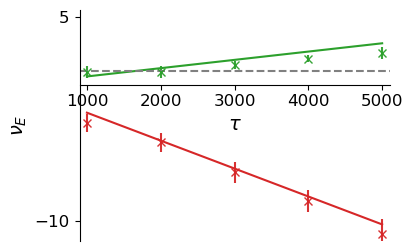

In [7]:
### plot the numerical error bar and theoretical eigvchn_theosss  
NNN = np.array([1000,2000,3000,4000,5000])  
fig,ax=plt.subplots(figsize=(4,3))
alphass=0.95
ax.errorbar(NNN,np.nanmean(eigvchn_series_NscaledProb[:,:,0].real,axis=1),yerr=np.nanstd(eigvchn_series_NscaledProb[:,:,0].real,axis=1),fmt='x',color='tab:red',ecolor='tab:red',alpha=alphass,ls='',elinewidth=1.5)
# ax.plot(NNN, eigvchn_theosss[:,0],marker='o',color='tab:red',alpha=1,lw=1.5)
ax.plot(NNN, eigvchn_theosss[:,0],color='tab:red',alpha=1,lw=1.5)

ax.errorbar(NNN,np.nanmean(eigvchn_series_NscaledProb[:,:,1].real,axis=1),yerr=np.nanstd(eigvchn_series_NscaledProb[:,:,1].real,axis=1),fmt='x',color='tab:green',ecolor='tab:green',alpha=alphass,ls='',elinewidth=1.5)
# ax.plot(NNN, eigvchn_theosss[:,1],marker='o',color='tab:green',alpha=1,lw=1.5)
ax.plot(NNN, eigvchn_theosss[:,1],color='tab:green',alpha=1,lw=1.5)
### plot the y=1 line
ax.plot([900,5100],[1,1],'--',color='gray')

### design the axes
ax.set_xlim(900,5100)
ax.set_xticks(NNN)
ax.set_ylim(-11.5,5.5)
ax.set_yticks([-10,5])
### move the axes to the center
# ax.spines['left'].set_position(('data', 0))
ax.spines['bottom'].set_position(('data', 0))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel(r'$\tau$',fontsize=14)
ax.set_ylabel(r'$\nu_{E}$',fontsize=14)
ax.tick_params(labelsize=12)
# ax.set_title(r'$\nu_{E}$',fontsi
plt.show()

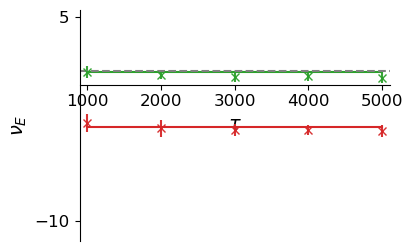

In [8]:
### plot the numerical error bar and theoretical eigvchn_theosss  
NNN = np.array([1000,2000,3000,4000,5000])  
fig,ax=plt.subplots(figsize=(4,3))
alphass=0.95
ax.errorbar(NNN,np.nanmean(eigvchn_series_NscaledNum[:,:,0].real,axis=1),yerr=np.nanstd(eigvchn_series_NscaledNum[:,:,0].real,axis=1),fmt='x',color='tab:red',ecolor='tab:red',alpha=alphass,ls='',elinewidth=1.5)
# ax.plot(NNN, eigvchn_theo[:,0],marker='o',color='tab:red',alpha=1,lw=1.5)
ax.plot(NNN, eigvchn_theo[:,0],color='tab:red',alpha=1,lw=1.5)

ax.errorbar(NNN,np.nanmean(eigvchn_series_NscaledNum[:,:,1].real,axis=1),yerr=np.nanstd(eigvchn_series_NscaledNum[:,:,1].real,axis=1),fmt='x',color='tab:green',ecolor='tab:green',alpha=alphass,ls='',elinewidth=1.5)
# ax.plot(NNN, eigvchn_theo[:,1],marker='o',color='tab:green',alpha=1,lw=1.5)
ax.plot(NNN, eigvchn_theo[:,1],color='tab:green',alpha=1,lw=1.5)

### plot the y=1 line
ax.plot([900,5100],[1,1],'--',color='gray')

### design the axes
ax.set_xlim(900,5100)
ax.set_xticks(NNN)
ax.set_ylim(-11.5,5.5)
ax.set_yticks([-10,5])
### move the axes to the center
# ax.spines['left'].set_position(('data', 0))
ax.spines['bottom'].set_position(('data', 0))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel(r'$\tau$',fontsize=14)
ax.set_ylabel(r'$\nu_{E}$',fontsize=14)
ax.tick_params(labelsize=12)
# ax.set_title(r'$\nu_{E}$',fontsi
plt.show()

#### Backup

In [ ]:
for seed in {0..36}; do
./run_secorder 1500 0.2 0.0 0.0 0.0 0 $seed
./run_secorder 1500 0.2 0.2 0.1 0.1 1 $seed
./run_secorder 1500 0.2 0.4 0.2 0.2 1 $seed
./run_secorder 1500 0.2 0.6 0.3 0.3 1 $seed
./run_secorder 1500 0.2 0.8 0.4 0.4 1 $seed
./run_secorder 1500 0.2 1.0 0.5 0.5 1 $seed
./run_secorder 1500 0.2 1.2 0.6 0.6 1 $seed
./run_secorder 1500 0.2 1.4 0.7 0.7 1 $seed
./run_secorder 1500 0.2 1.6 0.8 0.8 1 $seed
./run_secorder 1500 0.2 1.8 0.9 0.9 1 $seed

done

In [15]:
def list_to_dict(lst, string):
    """
    Transform a list of variables into a dictionary.
    Parameters
    ----------
    lst : list
        list with all variables.
    string : str
        string containing the names, separated by commas.
    Returns
    -------
    d : dict
        dictionary with items in which the keys and the values are specified
        in string and lst values respectively.
    """
    string = string[0]
    string = string.replace(']', '')
    string = string.replace('[', '')
    string = string.replace('\\', '')
    string = string.replace(' ', '')
    string = string.replace('\t', '')
    string = string.replace('\n', '')
    string = string.split(',')
    d = {s: v for s, v in zip(string, lst)}
    return d

In [ ]:
for seed in {1..37}; do
./run_secorder 1500 0.15 1.4 0.7 0.7 1 $seed
done

In [95]:
tau_series,alpha_series

(array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
        0.225]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))

In [96]:
kE, kI = 240,60
css = np.zeros(2)
css[0]=240/800 
css[1]=240/1600
css

array([0.3 , 0.15])

In [100]:
alpha_sample=0.6
CHNNUM = (alpha_sample+1)*c**2*N**2
CHNNUM_ = (0.7+1)*0.2**2*1500**2
print(CHNNUM,CHNNUM_)
alphass = np.zeros(2)
alphass[0] = CHNNUM/1000**2/css[0]**2-1
alphass[1] = CHNNUM/2000**2/css[1]**2-1
print(alphass)

144000.00000000003 153000.0
[0.6 0.6]


In [62]:
# # ccccs = 300/np.array([1000,1250,1500,1750,2000])###（CE+CI)/N
# ccccs = 300/np.array([1000,2000,3000,4000,5000])###（CE+CI)/N(larger)
# print(ccccs)
# ### compute rhos 
# taussss = (ccccs**2*(1+0.6)-ccccs**2)/ccccs/(1-ccccs)
# print(taussss)
# Nssss = np.array([1000,1250,1500,1750,2000])
# Nssss = np.array([1000,2000,3000,4000,5000])
# print(Nssss)

ccccs = 300/np.array([1000,2000,3000,4000,5000])###（CE+CI)/N(larger)
print(ccccs)
### compute rhos 
taussss = (ccccs**2*(1+0.6)-ccccs**2)/ccccs/(1-ccccs)
print(taussss)
Nssss = np.array([1000,2000,3000,4000,5000])
print(Nssss)

[0.3   0.15  0.1   0.075 0.06 ]
[0.25714286 0.10588235 0.06666667 0.04864865 0.03829787]
[1000 2000 3000 4000 5000]


In [82]:
''' Parameters used for all networks (reciprocal and chain)'''

# c [0.2      ........      ]
# tau [0.15 ......]
# N [1000 1250 1500 1750 2000]
J = 1/np.sqrt(1500)*0.5
### get the current path location and read the data file
import os
strr= os.getcwd()
print(strr)

c = np.ones(5)*0.2
taus = np.array([0.15,0.15,0.15,0.15,0.15])
# sigma2 = N*c*(1-c)*J**2
g, gamma = 6.8, 1/4.0#1.5,1/1.# 6.8, 1/4.0#1.5,1/1.#
ALPHAE, ALPHAI = 4/5, 1/5
ce, ci = c,c            
### theoretical prediction of the eigenvalues

org_k = J*Nssss*(ALPHAE-g*ALPHAI)/2.0
eigvchn_theosss = np.zeros((len(ccccs),2))
eigvchn_theosss[:,0] = org_k*(c+np.sqrt(c**2+4*c*(1-c)*taus))
eigvchn_theosss[:,1] = org_k*(c-np.sqrt(c**2+4*c*(1-c)*taus))

print(eigvchn_theosss[:,0])
print(eigvchn_theosss[:,1])

''' Parameters used for all networks (reciprocal and chain)'''

e:\Dropbox\DailyWork\Allen_project\sonets
[ -2.05602353  -4.11204706  -6.16807059  -8.22409413 -10.28011766]
[0.61010975 1.2202195  1.83032925 2.44043899 3.05054874]


' Parameters used for all networks (reciprocal and chain)'